In [2]:
from preprocessing.preprocessing import *
from visualization.general_plots import plot_class_frequencies

# Preprocessing
This notebook shows the steps that were taken in order to process our dataset.

## Loading the data
First, the data is loaded via the load_dataset() method.
Then, all data elements without any diabetes information are removed as these are not relevant for our purpose.
We then select the columns we want to use (i.e. all columns relating to physical health) and rename the columns for better readability.

In [3]:
complete_dataset = load_dataset()
complete_dataset = complete_dataset.dropna(subset=['DIABETE3'])
complete_dataset = complete_dataset[relevant_columns]
complete_dataset.columns = readable_column_names
print(complete_dataset.shape)

(441449, 29)


At this stage, there are 441,449 data elements in the dataset.
## Removing unnecessary data entries
Next, all elements with unknown or refused values are removed.

In [4]:
complete_dataset = remove_refused_columns(complete_dataset)  # removes ca. 115k columns
complete_dataset = remove_unknown_columns(complete_dataset)  # removes ca. 37k columns
print(complete_dataset.shape)

(288735, 29)


This leaves us with 288,735 data elements.
## Splitting into dataset and target
Now the complete dataset is split into the actual dataset and the target.

In [23]:
target = pd.DataFrame(complete_dataset["Diabetes"])
dataset = complete_dataset.drop(columns="Diabetes")
dataset = dataset.fillna(0)

In [24]:
dataset.head()

,GenHealth,PhysHealth,MentHealth,Healthcare,MedCost,Checkup,HighBP,HighChol,HeartAttack,AngiCoro,...,Height,Weight,BMI,Education,Alcohol,Smoking,FruitCons,VegetCons,PhysActivity,Muscles
0,5.0,15.0,18.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,178.0,12701.0,4.0,2.0,1.0,3.0,2.0,1.0,4.0,2.0
1,3.0,88.0,88.0,2.0,1.0,4.0,3.0,2.0,2.0,2.0,...,173.0,7484.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0
3,5.0,30.0,30.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,170.0,8165.0,3.0,2.0,1.0,4.0,1.0,2.0,4.0,2.0
5,2.0,88.0,88.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,157.0,6577.0,3.0,1.0,1.0,4.0,1.0,1.0,1.0,2.0
6,2.0,88.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,168.0,6713.0,2.0,3.0,1.0,4.0,1.0,1.0,1.0,2.0


In [25]:
target.head()

,Diabetes
0,3.0
1,3.0
3,3.0
5,3.0
6,3.0


To determine our baseline for testing we look at the percentage of no (3.0) values in the target, since always predicting no is our baseline to beat.

In [33]:
target_squeezed = target.squeeze()
class_dist = target_squeezed.value_counts()
baseline = class_dist[3.0] / len(target)
print("Baseline = {}".format(baseline))

Baseline = 0.8501774983981852


Our baseline is 85.02%.
## Normalization
Next, all numerical values are normalized. The columns PhysHealth and MentHealth represent the number of days in the last month were the interviewee did not
feel well physically / mentally. It is a number between 1 and 30, with the value 88 meaning zero days. For this reason, the value 88 is replaced by 0 before normalization.
A simple MinMaxScalar is used to normalize the respective columns.

In [8]:
scaler = MinMaxScaler()
dataset["PhysHealth"] = dataset["PhysHealth"].replace(88, 0)
dataset["MentHealth"] = dataset["MentHealth"].replace(88, 0)
dataset[["PhysHealth", "MentHealth", "Height", "Weight"]] = scaler.fit_transform(dataset[["PhysHealth", "MentHealth", "Height", "Weight"]])

In [9]:
dataset.head()

,GenHealth,PhysHealth,MentHealth,Healthcare,MedCost,Checkup,HighBP,HighChol,HeartAttack,AngiCoro,...,Height,Weight,BMI,Education,Alcohol,Smoking,FruitCons,VegetCons,PhysActivity,Muscles
0,5.0,0.5,0.6,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.777293,0.438192,4.0,2.0,1.0,3.0,2.0,1.0,4.0,2.0
1,3.0,0.0,0.0,2.0,1.0,4.0,3.0,2.0,2.0,2.0,...,0.755459,0.258203,3.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0
3,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,0.742358,0.281697,3.0,2.0,1.0,4.0,1.0,2.0,4.0,2.0
5,2.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,0.685590,0.226910,3.0,1.0,1.0,4.0,1.0,1.0,1.0,2.0
6,2.0,0.0,0.1,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.733624,0.231603,2.0,3.0,1.0,4.0,1.0,1.0,1.0,2.0


## Encoding
The result of the normalization is a finished, label-encoded dataset which can be accessed via the
**preprocessing_label_encoding.get_preprocessed_brfss_dataset_label_encoded()** method.
However, we also want to provide a one hot encoded variant of the dataset in order to test multiple
encoding variants. This is implemented in the **preprocessing_one_hot_encoding.py** file.
We implemented two different kinds of one hot encoding.
### 1. Encoding only ordinal columns with more than two choices
The first variant is encoding all columns with more than two choices (i.e. all columns that are not simply yes
or no).

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Excludes yes/no columns
ordinal_columns = ["GenHealth", "Checkup", "HighBP", "Income", "Age", "BMI", "Education", "Smoking", "PhysActivity"]

def get_preprocessed_brfss_dataset_one_hot_encoded(target_one_hot_encoded=False) -> Tuple[DataFrame, DataFrame]:
    dataset, target = get_preprocessed_brfss_dataset()
    one_hot_encoder = OneHotEncoder()
    encoded = pd.DataFrame(
        one_hot_encoder.fit_transform(dataset[ordinal_columns]).toarray(),
        columns=one_hot_encoder.get_feature_names_out())
    dataset = dataset.join(encoded)
    dataset = dataset.drop(columns=ordinal_columns)
    if target_one_hot_encoded:
        target = pd.DataFrame(one_hot_encoder.fit_transform(target).toarray(), columns=diabetes_columns)
    return dataset, target

In [11]:
dataset, target = get_preprocessed_brfss_dataset_one_hot_encoded()
dataset.head()

,index,PhysHealth,MentHealth,Healthcare,MedCost,HighChol,HeartAttack,AngiCoro,Stroke,Asthma,...,Education_3.0,Education_4.0,Smoking_1.0,Smoking_2.0,Smoking_3.0,Smoking_4.0,PhysActivity_1.0,PhysActivity_2.0,PhysActivity_3.0,PhysActivity_4.0
0,0,0.5,0.6,1.0,2.0,1.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,5,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,6,0.0,0.1,1.0,2.0,1.0,2.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [12]:
target.head()

,Diabetes
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0


The method also provides the parameter **target_one_hot_encoded** which can be used to also one hot encode
the target variable.

In [13]:
dataset, target = get_preprocessed_brfss_dataset_one_hot_encoded(True)
target.head()

,Yes,"Yes, but only during pregnancy",No,"No, but pre-diabetes"
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


### 2. Encoding all ordinal columns
The second variant encodes all ordinal columns (including yes/no columns). It also provides the parameter
**target_one_hot_encoded**.

In [14]:
# Includes yes/no columns
all_ordinal_columns = ["GenHealth", "Healthcare", "MedCost", "Checkup", "HighBP", "HighChol", "HeartAttack", "AngiCoro",
                       "Stroke", "Asthma", "Arthritis", "Kidney", "Sex", "Income", "SodiumSalt", "Age", "BMI",
                       "Education", "Alcohol", "Smoking", "FruitCons", "VegetCons", "PhysActivity", "Muscles"]

def get_preprocessed_brfss_dataset_one_hot_encoded_all_columns(target_one_hot_encoded=False) \
        -> Tuple[DataFrame, DataFrame]:
    dataset, target = get_preprocessed_brfss_dataset()
    one_hot_encoder = OneHotEncoder()
    encoded = pd.DataFrame(
        one_hot_encoder.fit_transform(dataset[all_ordinal_columns]).toarray(),
        columns=one_hot_encoder.get_feature_names_out())
    dataset = dataset.join(encoded)
    dataset = dataset.drop(columns=all_ordinal_columns)
    if target_one_hot_encoded:
        target = pd.DataFrame(one_hot_encoder.fit_transform(target).toarray(), columns=diabetes_columns)
    return dataset, target

In [15]:
dataset, target = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns()
dataset.head()

,index,PhysHealth,MentHealth,Height,Weight,GenHealth_0.0,GenHealth_1.0,GenHealth_2.0,GenHealth_3.0,GenHealth_4.0,...,FruitCons_1.0,FruitCons_2.0,VegetCons_1.0,VegetCons_2.0,PhysActivity_1.0,PhysActivity_2.0,PhysActivity_3.0,PhysActivity_4.0,Muscles_1.0,Muscles_2.0
0,0,0.5,0.6,0.777293,0.438192,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,0.0,0.0,0.755459,0.258203,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3,1.0,1.0,0.742358,0.281697,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,5,0.0,0.0,0.685590,0.226910,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,6,0.0,0.1,0.733624,0.231603,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


As a result, only the four normalized numerical values remain not encoded.

## Sampling

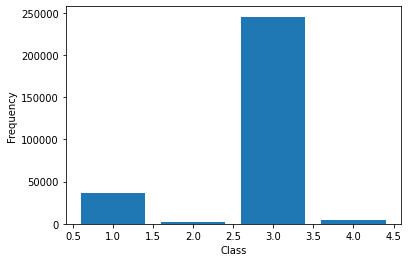

In [16]:
plot_class_frequencies(target)

It is visible that the dataset is very unbalanced, especially with respect to the value diabetes = 3.0 (no).
This is why sampling is needed.
We implemented over- and undersampling to test both approaches.

In [17]:
def oversample_dataset(dataset, target) -> Tuple[DataFrame, DataFrame]:
    over_sampler = RandomOverSampler()
    brfss_balanced, brfss_balanced_target = over_sampler.fit_resample(dataset, target)
    return brfss_balanced, brfss_balanced_target


def undersample_dataset(dataset, target) -> Tuple[DataFrame, DataFrame]:
    under_sampler = RandomUnderSampler()
    brfss_balanced, brfss_balanced_target = under_sampler.fit_resample(dataset, target)
    return brfss_balanced, brfss_balanced_target

We then provide methods to combine each of the encoding approaches with each of the sampling variants
for easy access from within the notebooks. The following is the example for label encoding.

In [18]:
def get_preprocessed_brfss_dataset_label_encoded_oversampled() -> Tuple[DataFrame, DataFrame]:
    dataset, target = get_preprocessed_brfss_dataset()
    dataset, target = oversample_dataset(dataset, target)
    return dataset, target


def get_preprocessed_brfss_dataset_label_encoded_undersampled() -> Tuple[DataFrame, DataFrame]:
    dataset, target = get_preprocessed_brfss_dataset()
    dataset, target = undersample_dataset(dataset, target)
    return dataset, target

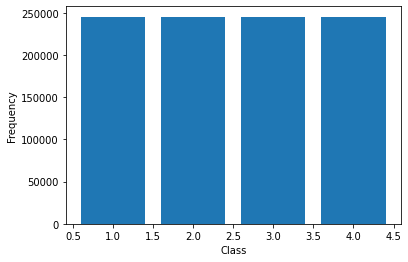

In [19]:
dataset, target = get_preprocessed_brfss_dataset_label_encoded_oversampled()
plot_class_frequencies(target)

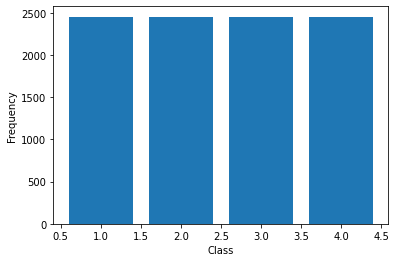

In [20]:
dataset, target = get_preprocessed_brfss_dataset_label_encoded_undersampled()
plot_class_frequencies(target)